In [1]:
import yfinance as yf
import sys
import pymongo
import pandas as pd
import numpy as np
import plotly.express as px
import yaml

In [2]:
def fetch_and_store_sandp_components(collection, url):

    df_list = pd.read_html(url)
    if len(df_list) == 0:
        raise Exception(f"No data found on html read of url: {url}")
    df = df_list[0]  # First table contains tickers

    df = df.rename(columns={"GICS Sector": "GICSSector", "GICS Sub-Industry": "GICSSubIndustry"})

    records = [
        {
            "Ticker": row.Symbol.replace(".", "-"),
            "Security": row.Security,
            "GICSSector": row.GICSSector,
            "GICSSubIndustry": row.GICSSubIndustry
        }
        for row in df.itertuples(index=False)
    ]

    collection.insert_many(records)

In [3]:
def fetch_and_store_prices(collection, components, start_date, end_date):
    for component in components.itertuples(index=False):
        
        df = yf.download(component.Ticker, start=start_date, end=end_date)

        df.columns = df.columns.get_level_values(0)
        records = [
            {
                "Ticker": component.Ticker,
                "Date": row.Index.strftime("%Y-%m-%d"),
                "Open": row.Open,
                "High": row.High,
                "Low": row.Low,
                "Close": row.Close,
                "Volume": row.Volume
            }
            for row in df.itertuples()
        ]
 
        collection.insert_many(records)
        

In [4]:
with open("config.yaml") as stream:
    config = yaml.safe_load(stream)

sp500_ticker_url = config["sp500_ticker_url"]
start_date = config["data_start_date"]
end_date = config["data_end_date"]

In [5]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [6]:
db = client["market_data"]

In [7]:
ticker_collection = db["sp500_components"]

In [8]:
fetch_and_store_sandp_components(ticker_collection, sp500_ticker_url)


In [9]:
collection = db["stock_prices"]

In [10]:
sp500_components = pd.DataFrame(list(ticker_collection.find({}, {"_id": 0, "Ticker": 1, "Security": 1})))

In [11]:
%%capture
fetch_and_store_prices(collection, sp500_components, start_date=start_date, end_date=end_date);

In [11]:
plot_tickers = ["AAPL", "GOOG", "MSFT", "TSLA", "NVDA"]
query = {"Ticker": {"$in": plot_tickers}} 
cursor = collection.find(query, {"_id": 0, "Ticker": 1, "Date": 1, "Close": 1})
df = pd.DataFrame(list(cursor))

In [12]:
grouped_df = df.groupby(["Date", "Ticker"]).last().reset_index()

In [13]:
df_pivot = grouped_df.pivot(index="Date", columns="Ticker", values="Close")

In [14]:
df_pivot.columns = df_pivot.columns.get_level_values(0)

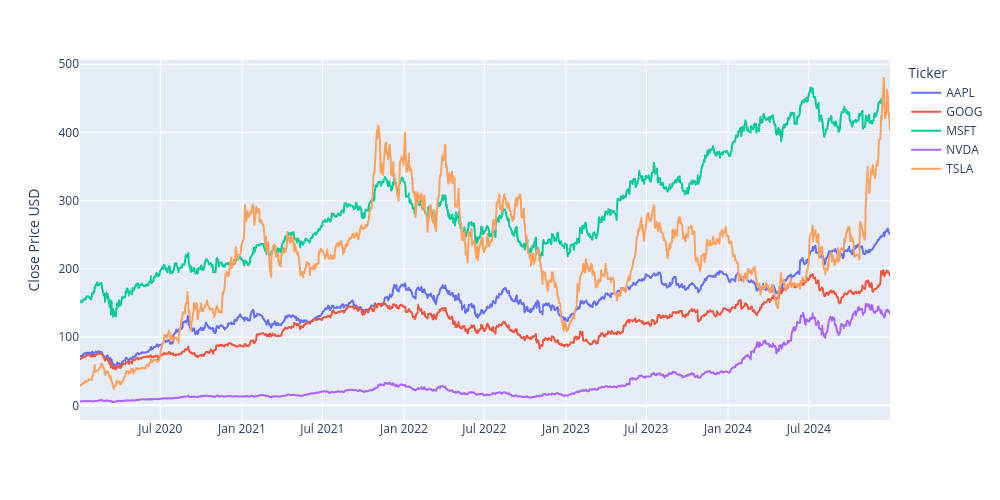

In [20]:
fig = px.line(df_pivot).update_layout(xaxis_title=None, yaxis_title="Close Price USD", legend_title="Ticker", width=1000, height=500)
fig.show("png")